In [4]:
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation" #"/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

# Run this cell to import necessary libraries
import json
import yaml
import pickle
import logging
import numpy as np
import matplotlib.pyplot as plt


# --- Imports for the new interactive framework ---
import plotly.graph_objects as go
from ipywidgets import Dropdown, IntRangeSlider, FloatSlider, Label, VBox, HBox, Output, Button, Textarea
from IPython.display import display

# --- Your Pipeline's Imports ---
# Make sure your scint_analysis package is importable
# (You may need to add its path using sys.path.insert)
#try:
from scint_analysis import config, pipeline, plotting
from scint_analysis.analysis import lorentzian_model_3_comp, lorentzian_model_2_comp, lorentzian_model_1_comp
from scint_analysis.core import ACF
from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses
#except ImportError as e:
#    logging.error(f"Could not import scint_analysis. Make sure it's in your Python path. {e}")

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/wilhelm_dsa.yaml' #'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/wilhelm_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize the Pipeline Object ---
print("\n--- Initializing Scintillation Pipeline ---")
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# --- 3. Prepare Data for Interactive Use ---
# This new step loads the data and populates scint_pipeline.masked_spectrum
scint_pipeline.prepare_data()

# --- 4. Run the Interactive Window Selector ---
# ==============================================================================
# Interactive On/Off-Pulse Window Selector
# ==============================================================================
# This tool allows you to visually select the on-pulse and off-pulse windows
# and save them directly to the burst's YAML configuration file.

if 'scint_pipeline' not in locals() or scint_pipeline.masked_spectrum is None:
    print("Please run the initial pipeline setup cells first.")
else:
    # --- Helper function to update the YAML file ---
    def update_rfi_config(config_path, key, value_list):
        try:
            with open(config_path, 'r') as f:
                config_data = yaml.safe_load(f)
            rfi_section = config_data.setdefault('analysis', {}).setdefault('rfi_masking', {})
            rfi_section[key] = value_list
            with open(config_path, 'w') as f:
                yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
            return f"Success! Updated '{key}' to {value_list} in {config_path.split('/')[-1]}"
        except Exception as e:
            return f"Error updating YAML: {e}"

    # --- Main Interactive Function ---
    def interactive_window_selector(pipeline_obj, config_path):
        spectrum = pipeline_obj.masked_spectrum
        time_series = spectrum.get_profile()
        time_axis = spectrum.times
        max_bin = len(time_axis) - 1
        total_duration = time_axis[-1] - time_axis[0]
        
        # Find the center of the pulse to center the zoom
        peak_time_bin = np.argmax(time_series.filled(0))
        center_time = time_axis[peak_time_bin]

        # --- Create Widgets ---
        on_pulse_slider = IntRangeSlider(value=[max_bin // 2, 3 * max_bin // 4], min=0, max=max_bin, step=1, description='On-Pulse Bins:', style={'description_width': 'initial'}, layout={'width': '95%'})
        off_pulse_slider = IntRangeSlider(value=[0, max_bin // 4], min=0, max=max_bin, step=1, description='Off-Pulse Bins:', style={'description_width': 'initial'}, layout={'width': '95%'})
        
        # NEW: A slider to control the zoom *width* around the pulse center
        zoom_width_slider = FloatSlider(
            value=total_duration,
            min=total_duration * 0.01, # Min zoom is 1% of total duration
            max=total_duration,
            step=total_duration / 200,
            description='Zoom Width (s):',
            readout_format='.3f',
            style={'description_width': 'initial'},
            layout={'width': '95%'}
        )
        
        save_button = Button(description="Save Windows to YAML", button_style='primary', icon='save')
        status_label = Label(value="Adjust sliders to select regions.")
        plot_output = Output()

        # --- Plotting Function ---
        def draw_plot(on_pulse_range, off_pulse_range, zoom_width):
            with plot_output:
                plot_output.clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(12, 5))
                
                # Calculate the zoom window centered on the peak
                zoom_min = center_time - (zoom_width / 2)
                zoom_max = center_time + (zoom_width / 2)
                
                ax.plot(time_axis, time_series, color='navy', label='Profile')
                ax.axvspan(time_axis[on_pulse_range[0]], time_axis[on_pulse_range[1]], color='cyan', alpha=0.4, label='On-Pulse')
                ax.axvspan(time_axis[off_pulse_range[0]], time_axis[off_pulse_range[1]], color='orange', alpha=0.4, label='Off-Pulse (Noise)')
                
                ax.set_title("On/Off-Pulse Window Selector")
                ax.set_xlabel("Time (s)"), ax.set_ylabel("Power")
                ax.grid(True, linestyle=':'), ax.legend()
                ax.set_xlim(zoom_min, zoom_max) # Apply the centered zoom
                plt.show()

        # --- Callbacks ---
        def on_change(change):
            draw_plot(on_pulse_slider.value, off_pulse_slider.value, zoom_width_slider.value)

        def on_save_clicked(b):
            on_pulse_window = list(on_pulse_slider.value)
            off_pulse_window = list(off_pulse_slider.value)
            msg1 = update_rfi_config(config_path, 'manual_burst_window', on_pulse_window)
            msg2 = update_rfi_config(config_path, 'manual_noise_window', off_pulse_window)
            status_label.value = f"{msg1} | {msg2}"
            pipeline_obj.config['analysis']['rfi_masking']['manual_burst_window'] = on_pulse_window
            pipeline_obj.config['analysis']['rfi_masking']['manual_noise_window'] = off_pulse_window

        # --- Link widgets and display ---
        on_pulse_slider.observe(on_change, names='value')
        off_pulse_slider.observe(on_change, names='value')
        zoom_width_slider.observe(on_change, names='value') # Connect the new slider
        save_button.on_click(on_save_clicked)
        
        dashboard = VBox([zoom_width_slider, on_pulse_slider, off_pulse_slider, plot_output, HBox([save_button, status_label])])
        display(dashboard)
        draw_plot(on_pulse_slider.value, off_pulse_slider.value, zoom_width_slider.value)

    # --- Run the interactive tool ---
    interactive_window_selector(scint_pipeline, BURST_CONFIG_PATH)

INFO: Loading burst configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/wilhelm_dsa.yaml
INFO: Loading telescope configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/


INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/
INFO: --- Preparing Data ---
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/
INFO: Loading and processing raw data...
INFO: Loading DynamicSpectrum from file: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/wilhelm.npz
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Applying RFI masking.
INFO: Using time downsampling factor of 16 for RFI statistical checks.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "wilhelm",
  "input_data_path": "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/wilhelm.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 8.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0,
      "manual_burst_window": [
        1307,
        1368
      ],
      "manual_noise_window": [
        0,
        624
      ]
    },
    "acf": {
      "num_subbands"

INFO: RFI MASKING: Using manually specified on-pulse window: [1307, 1368]
INFO: Using symmetric noise window of duration 61 bins.
INFO: Using downsampled noise statistics from bins 77 to 81.


Manual window set to [1307, 1368]


Iterative RFI Masking in Frequency Domain:  20%|██        | 1/5 [00:00<00:00, 113.15it/s]
INFO: Masked 3 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: --- Data Preparation Finished ---


INFO: Data already prepared. Skipping.
INFO: --- Starting Scintillation Pipeline for wilhelm ---
INFO: Applying polynomial baseline subtraction...
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating diagnostic plots...
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 37)
INFO: Generating diagnostic plot: On-Pulse Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/wilhelm_on_pulse_diagnostic.png


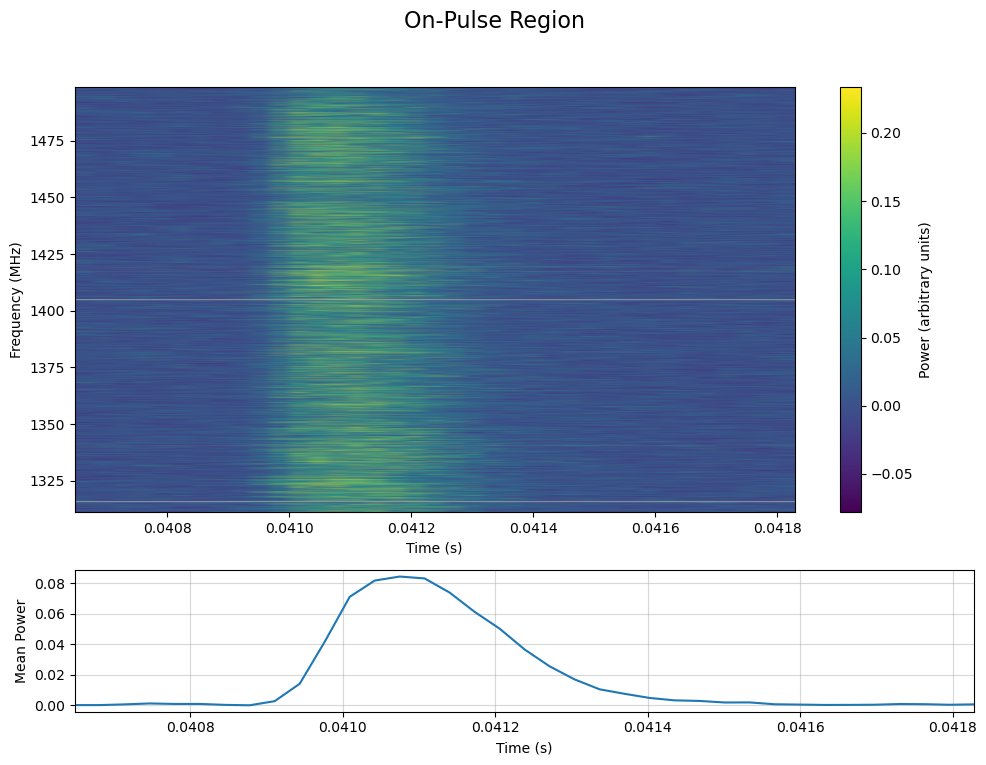

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 179)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/wilhelm_off_pulse_diagnostic.png


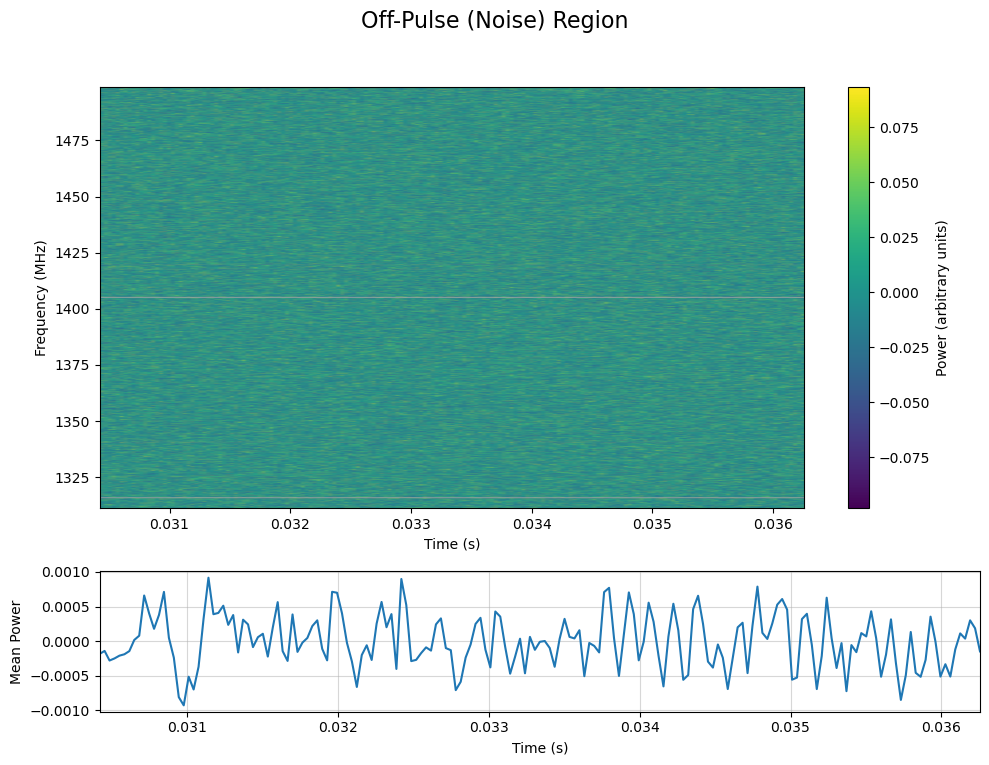

INFO: On/Off pulse diagnostic plots saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/wilhelm_baseline_diagnostic.png


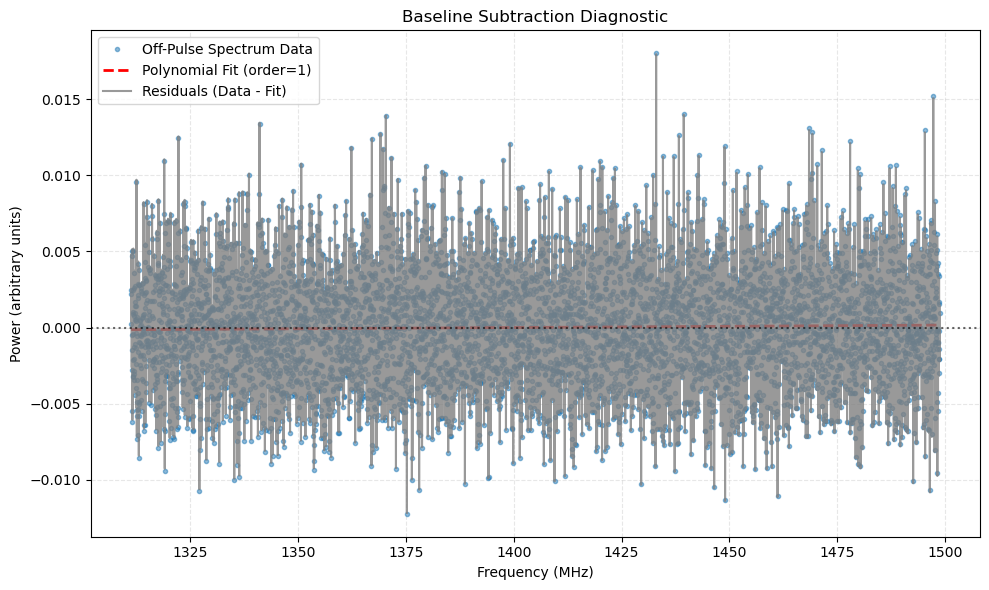

INFO: Noise modelling disabled by config.
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band: 100%|██████████| 2/2 [00:00<00:00, 18.04it/s]
INFO: Saved ACF results to cache: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl
INFO: 'halt_after_acf' is set to True. Halting pipeline as requested.


--- Pipeline Execution Finished ---


In [5]:
# --- 4. Run the Pipeline ---
# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")

In [ ]:
# ==============================================================================
# Manual ACF Fitting Notebook
# ==============================================================================
# This notebook allows for manual, interactive fitting of sub-banded ACFs
# independent of the main automated pipeline, using the lmfit library for
# consistency with the main pipeline.

# Imports 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import yaml 
from lmfit import Model # Using lmfit instead of scipy.curve_fit

# Imports for Interactive Controls
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, FloatText, Dropdown, VBox, HBox, Button, Output, Textarea, Label, Checkbox
from IPython.display import display

# Imports from your Scintillation Analysis Pipeline
try:
    from scint_analysis.analysis import (
        lorentzian_model_1_comp,
        lorentzian_model_2_comp,
        lorentzian_model_3_comp
    )
    from scint_analysis.core import ACF
except ImportError as e:
    print(f"Error: Could not import from scint_analysis package. Make sure it is installed or in the Python path. {e}")

# Load Pre-Calculated ACF Data
ACF_RESULTS_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl'

with open(ACF_RESULTS_PATH, 'rb') as f:
    acf_results = pickle.load(f)
print(f"Successfully loaded ACF results from '{ACF_RESULTS_PATH}'")
num_subbands = len(acf_results['subband_acfs'])
print(f"Found data for {num_subbands} sub-bands.")


# Model Configuration Hub
MODEL_CONFIG = {
    '1-Component Lorentzian': {
        'func': lorentzian_model_1_comp,
        'prefix': 'l1_',
        'param_names': ['gamma1', 'm1', 'c1'],
        'hook': lambda p: (p['l1_gamma1'].set(min=1e-6), p['l1_m1'].set(min=0))
    },
    '2-Component Lorentzian': {
        'func': lorentzian_model_2_comp,
        'prefix': 'l2_',
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'c2'],
        'hook': lambda p: (
            p['l2_gamma1'].set(min=1e-6), p['l2_gamma2'].set(min=1e-6),
            p['l2_m1'].set(min=0), p['l2_m2'].set(min=0))
    },
    '3-Component Lorentzian': {
        'func': lorentzian_model_3_comp,
        'prefix': 'l3_',
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3'],
        'hook': lambda p: (
            p['l3_gamma1'].set(min=1e-6), p['l3_gamma2'].set(min=1e-6), p['l3_gamma3'].set(min=1e-6),
            p['l3_m1'].set(min=0), p['l3_m2'].set(min=0), p['l3_m3'].set(min=0))
    }
}


# Main Interactive Fitting Function
if acf_results:
    # Create Widgets
    subband_slider = IntSlider(min=0, max=num_subbands-1, step=1, value=0, description='Sub-band Index:')
    model_selector = Dropdown(options=MODEL_CONFIG.keys(), value='2-Component Lorentzian', description='Model:')
    max_lag_overall = max(np.max(np.abs(lags)) for lags in acf_results['subband_lags_mhz'])
    
    fit_range_min_text = FloatText(value=-max_lag_overall, description='Min Lag:')
    fit_range_max_text = FloatText(value=max_lag_overall, description='Max Lag:')
    
    fit_range_slider = FloatRangeSlider(
        value=[-max_lag_overall, max_lag_overall],
        min=-max_lag_overall,
        max=max_lag_overall,
        step=0.1,
        description='Fit Range Slider:',
        continuous_update=False, 
        style={'description_width': 'initial'}
    )

    # Checkbox to control use of uncertainties
    ignore_errors_checkbox = Checkbox(value=False, description="Ignore Pre-calculated Uncertainties", indent=False)
    
    fit_button = Button(description="Perform Fit", button_style='success', icon='cogs')
    print_fits_button = Button(description="Print Stored Fits", button_style='info', icon='print')
    update_yaml_button = Button(description="Save Evolving Guess to YAML", button_style='warning', icon='save')
    
    param_controls_container = VBox([])
    plot_output = Output()
    results_output_area = Textarea(layout={'width': '98%', 'height': '200px'}, placeholder="Results from 'Print Stored Fits' will appear here.")
    status_label = Label(value="")
    fit_stats_label = Label(value="Fit Stats: N/A")

    all_fits_storage = {}

    def create_param_controls(model_name):
        config = MODEL_CONFIG[model_name]
        param_names = config['param_names']
        all_param_widgets = []
        num_components = (len(param_names) - 1) // 2
        
        for i in range(num_components):
            gamma_name = config['prefix'] + param_names[i*2]
            m_name = config['prefix'] + param_names[i*2 + 1]
            gamma_slider = FloatSlider(min=0, max=15, step=0.01, value=0.1, description=f'{gamma_name}:')
            m_slider = FloatSlider(min=0, max=2, step=0.01, value=0.5, description=f'{m_name}:')
            alpha_box = FloatText(value=4.0, description=f'{gamma_name} α:')
            component_box = HBox([gamma_slider, m_slider, alpha_box])
            all_param_widgets.append(component_box)

        c_name = config['prefix'] + param_names[-1]
        c_slider = FloatSlider(min=-0.2, max=0.2, step=0.001, value=0.0, description=f'{c_name}:')
        all_param_widgets.append(c_slider)
        param_controls_container.children = tuple(all_param_widgets)
        
        for box in all_param_widgets:
            if isinstance(box, HBox):
                for widget in box.children: widget.observe(on_visuals_change, names='value')
            else:
                box.observe(on_visuals_change, names='value')

    def get_current_params():
        params = []
        for box in param_controls_container.children:
            if isinstance(box, HBox): params.extend([box.children[0].value, box.children[1].value])
            else: params.append(box.value)
        return params

    def draw_plot(subband_idx, model_name, fit_range, initial_guesses, fit_result=None):
        with plot_output:
            plot_output.clear_output(wait=True)
            config = MODEL_CONFIG[model_name]
            model_func = config['func']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            lags, acf_data, acf_err = acf_results['subband_lags_mhz'][subband_idx], acf_results['subband_acfs'][subband_idx], acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
            
            range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1]) & (lags != 0)
            x_data, y_data = lags[range_mask], acf_data[range_mask]

            fig, ax = plt.subplots(figsize=(10, 6))
            ax.errorbar(lags, acf_data, yerr=acf_err, fmt='.', color='lightgray', label='All Data', capsize=3, alpha=0.5, zorder=1)
            ax.plot(x_data, y_data, '-', color='purple', alpha=0.5, label='Data in Fit Range')
            ax.axvspan(fit_range[0], fit_range[1], color='gray', alpha=0., zorder=0)

            y_guess = model_func(x_data, *initial_guesses)
            ax.plot(x_data, y_guess, '-', color='pink', label='Initial Guess', zorder=5)

            if fit_result and fit_result.success:
                ax.plot(x_data, fit_result.best_fit, 'k-', label='Final Fit', lw=2, zorder=10)

            ax.set_title(f"Assisted Fit for Sub-band {subband_idx} @ {center_freq:.2f} MHz ({model_name})")
            ax.set_xlabel("Frequency Lag (MHz)"), ax.set_ylabel("Correlation"), ax.set_ylim(-0.05, 0.1)
            ax.grid(True, linestyle=':'), ax.legend(loc='upper right')
            ax.set_xlim(fit_range[0]-2, fit_range[1]+2)
            ax.set_ylim(np.min(y_data)-0.05, np.max(y_data)+0.05)
            plt.show()

    def on_visuals_change(change):
        # When visuals change, clear the old fit stats
        fit_stats_label.value = "Fit Stats: N/A"
        draw_plot(subband_slider.value, model_selector.value, fit_range_slider.value, get_current_params())

    def on_fit_button_clicked(b):
        subband_idx, model_name, fit_range = subband_slider.value, model_selector.value, fit_range_slider.value
        initial_guesses = get_current_params()
        config = MODEL_CONFIG[model_name]
        
        lags, acf_data, acf_err = acf_results['subband_lags_mhz'][subband_idx], acf_results['subband_acfs'][subband_idx], acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
        range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1]) & (lags != 0)
        x_data, y_data = lags[range_mask], acf_data[range_mask]
        
        # Handle sigma based on checkbox 
        sigma = None
        avg_sigma_str = "N/A"
        # Only use sigma if the checkbox is NOT checked and errors exist
        if not ignore_errors_checkbox.value and acf_err is not None:
            sigma = acf_err[range_mask]
            # Calculate average sigma for display
            if sigma.size > 0:
                avg_sigma_str = f"{np.mean(sigma):.4f}"

        model = Model(config['func'], prefix=config['prefix'])
        params = model.make_params()
        for name, value in zip(config['param_names'], initial_guesses):
            params[config['prefix'] + name].set(value=value)
        if config.get('hook'):
            config['hook'](params)
        
        fit_result = None
        try:
            # Pass weights correctly
            weights = 1.0/sigma if sigma is not None else None
            fit_result = model.fit(y_data, params, x=x_data, weights=weights)

            if fit_result.success:
                all_fits_storage[subband_idx] = {'result': fit_result, 'model_name': model_name}
                fit_stats_label.value = f"Fit Stats: Avg. σ = {avg_sigma_str} | Reduced Chi-sq = {fit_result.redchi:.3f} | BIC = {fit_result.bic:.2f}"
            else:
                fit_stats_label.value = "Fit Stats: Fit did not converge."

        except Exception as e:
            fit_stats_label.value = f"Fit Stats: Error - {e}"
        
        draw_plot(subband_idx, model_name, fit_range, initial_guesses, fit_result=fit_result)


    def on_print_fits_clicked(b):
        output_str = ""
        for idx in sorted(all_fits_storage.keys()):
            fit_info = all_fits_storage[idx]
            result = fit_info['result']
            center_freq = acf_results['subband_center_freqs_mhz'][idx]
            output_str += f"--- Sub-band {idx} @ {center_freq:.2f} MHz (Model: {fit_info['model_name']}) ---\n"
            for name, param in result.params.items():
                output_str += f"  {name}: {param.value:.4f} +/- {param.stderr or 0.0:.4f}\n"
            output_str += "\n"
        results_output_area.value = output_str

    def on_update_yaml_clicked(b):
        try:
            subband_idx = subband_slider.value
            if subband_idx not in all_fits_storage:
                status_label.value = f"Error: No successful fit found for sub-band {subband_idx}. Please 'Perform Fit' first."
                return

            status_label.value = "Updating YAML file with best-fit parameters..."
            fit_info = all_fits_storage[subband_idx]
            result = fit_info['result']
            model_name_str = fit_info['model_name']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            model_key = model_name_str.replace('-Component Lorentzian', 'c_lor').replace(' ', '')
            
            evolving_guess_dict = {'reference_frequency_mhz': center_freq, 'components': [], 'constants': {}}
            component_widgets = [child for child in param_controls_container.children if isinstance(child, HBox)]
            
            for i, comp_box in enumerate(component_widgets):
                prefix = MODEL_CONFIG[model_name_str]['prefix']
                gamma_name = prefix + MODEL_CONFIG[model_name_str]['param_names'][i*2]
                m_name = prefix + MODEL_CONFIG[model_name_str]['param_names'][i*2 + 1]
                
                evolving_guess_dict['components'].append({
                    'name': f'component_{i+1}',
                    'gamma_guess': float(f"{result.params[gamma_name].value:.4f}"),
                    'gamma_scaling_index': comp_box.children[2].value,
                    'm_guess': float(f"{result.params[m_name].value:.4f}")
                })

            prefix = MODEL_CONFIG[model_name_str]['prefix']
            c_name_short = MODEL_CONFIG[model_name_str]['param_names'][-1]
            c_name_full = prefix + c_name_short
            evolving_guess_dict['constants'][c_name_short] = float(f"{result.params[c_name_full].value:.4f}")

            CONFIG_PATH = BURST_CONFIG_PATH
            with open(CONFIG_PATH, 'r') as f: config_data = yaml.safe_load(f)
            init_guess_section = config_data.setdefault('analysis', {}).setdefault('fitting', {}).setdefault('init_guess', {})
            init_guess_section[model_key] = evolving_guess_dict
            with open(CONFIG_PATH, 'w') as f: yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
            status_label.value = f"Success! Updated '{model_key}' guess in {CONFIG_PATH}."
        except Exception as e:
            status_label.value = f"Error: {e}"

    def on_model_change(change):
        create_param_controls(change['new'])
        on_visuals_change(None)

    def link_text_to_slider(change):
        min_val, max_val = fit_range_min_text.value, fit_range_max_text.value
        if min_val < max_val:
            fit_range_slider.unobserve(link_slider_to_text, names='value')
            fit_range_slider.value = (min_val, max_val)
            fit_range_slider.observe(link_slider_to_text, names='value')
            on_visuals_change(None)

    def link_slider_to_text(change):
        fit_range_min_text.value, fit_range_max_text.value = round(change.new[0], 2), round(change.new[1], 2)
        on_visuals_change(None)

    # --- Link Widgets ---
    subband_slider.observe(on_visuals_change, names='value')
    model_selector.observe(on_model_change, names='value')
    fit_button.on_click(on_fit_button_clicked)
    print_fits_button.on_click(on_print_fits_clicked)
    update_yaml_button.on_click(on_update_yaml_clicked)
    fit_range_slider.observe(link_slider_to_text, names='value')
    fit_range_min_text.observe(link_text_to_slider, names='value')
    fit_range_max_text.observe(link_text_to_slider, names='value')
    
    # --- Display Dashboard ---
    create_param_controls(model_selector.value)
    
    fit_range_controls = VBox([Label(value="Fit Lag Range (MHz):"), HBox([fit_range_min_text, fit_range_max_text]), fit_range_slider])
    
    # Add the new fit_stats_label to the layout
    dashboard = VBox([
        HBox([subband_slider, model_selector]), 
        fit_range_controls, 
        Label(value="Component Parameters (gamma, m, alpha) and Constants (c):"), 
        param_controls_container, 
        HBox([fit_button, print_fits_button, update_yaml_button]), 
        status_label, 
        fit_stats_label, # NEW
        plot_output, 
        results_output_area
    ])
    display(dashboard)
    on_visuals_change(None)
